# **Assignment 4 - Variational Autoencoders**

In this assignment, we will train a model to produce new human faces with variational autoencoders (VAEs). 
Variational autoencoders let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces (as we'll do in this assignment), high-resolution digital artwork and many more tasks. These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma and Wellings [1].

In this assignment, you will build, train and analyze a VAE with the CelebA dataset. You will analyze how well images can be reconstructed from the lower dimensional representations and try to generate images that look similar to the images in the CelebA dataset.

[1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013). 


# **Section 1: Variational Autoencoders**


Let us recall the structure of the variational autoencoder:

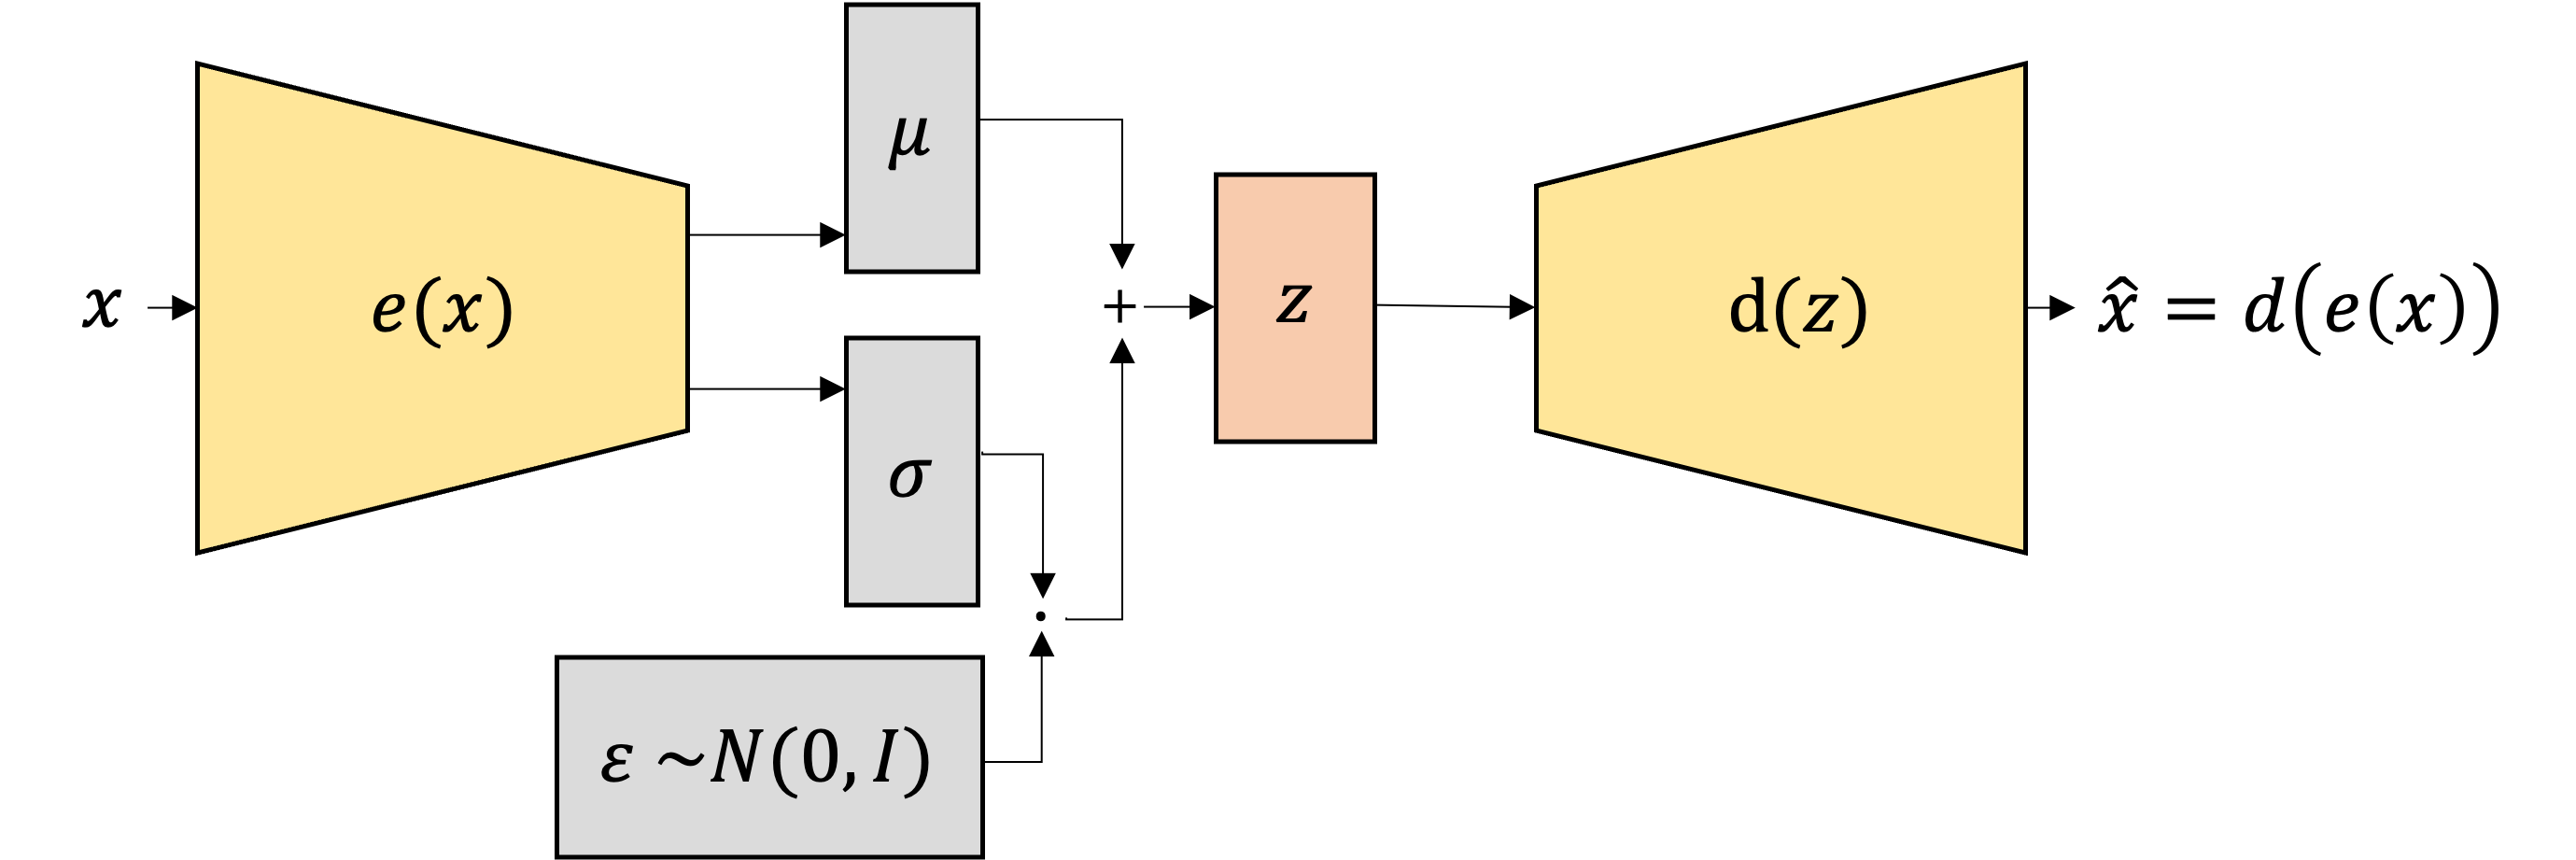

**Imports**

Before we begin, we import the needed libraries. 


You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.

In [ ]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
import os
import zipfile
import random

%pip install wget   
import wget

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=ddd2ef38ed1be8bf1d72812ba9c99a18d80e89c9e5ce7c3803b8161a48c2d59a
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Path to save the dataset.
PATH_TO_SAVE_MODEL = '/content/gdrive/My Drive/Deep Learning/Assignment 4' # TODO - UPDATE ME!

Mounted at /content/gdrive


Define random seeds in order to reproduce your results.

In [ ]:
# TO DO: Set random seeds - to your choice
torch.manual_seed(42)         # Insert any integer
torch.cuda.manual_seed(42)    # Insert any integer

## Question 1. Basic Principles (10 %)




### Part (a) -- 3%

What is the difference between deterministic autoencoder we saw in class and the variational autoencoder? 

### Write your explanation here

Deterministic autoencoders and variational autoencoders are two types of autoencoders that are used in deep learning for dimensionality reduction and feature learning.

A deterministic autoencoder is a neural network architecture that is used to learn a compressed representation of an input data in an unsupervised manner. It consists of two main components: an encoder and a decoder. The encoder maps the input data to a lower-dimensional latent space, and the decoder maps the latent representation back to the original space to reconstruct the input data. The goal of a deterministic autoencoder is to minimize the reconstruction error between the input data and its reconstruction.

A variational autoencoder (VAE) is a type of autoencoder that is used to learn a probabilistic latent representation of the input data. It consists of an encoder, a decoder, and a loss function that is based on the Kullback-Leibler divergence between the true posterior distribution of the latent representation and the approximate posterior distribution that is learned by the encoder. The goal of a VAE is to maximize the likelihood of the input data under the learned latent representation.

One key difference between deterministic autoencoders and VAEs is that VAEs are probabilistic models that can sample from the latent space and generate new data points, while deterministic autoencoders do not have this capability. This makes VAEs more flexible and powerful than deterministic autoencoders, as they can be used for tasks such as data generation and density estimation.

For example, consider a VAE that is trained to compress and reconstruct images of faces. The VAE's encoder can learn a probabilistic latent representation of the input images, and the decoder can generate new images by sampling from this latent space. The VAE can then be used to generate novel, realistic-looking images of faces by sampling from the latent space and passing the samples through the decoder. In contrast, a deterministic autoencoder would not be able to generate new images in this way.

### Part (b) -- 3%
In which manner Variational Autoencoder is trained? Explain.


### Write your explanation here

A variational autoencoder (VAE) is trained using an unsupervised learning approach, similar to how a traditional autoencoder is trained. The main difference is that the loss function used for training a VAE is based on the Kullback-Leibler divergence between the true posterior distribution of the latent representation and the approximate posterior distribution learned by the encoder.

The VAE consists of two main components: an encoder and a decoder. The encoder maps the input data to a lower-dimensional latent space, and the decoder maps the latent representation back to the original space to reconstruct the input data. The goal of the VAE is to learn a probabilistic latent representation of the input data that can be used to reconstruct the input data with a high degree of accuracy.

To train a VAE, we first need to define the encoder and decoder networks and specify the loss function. The loss function for a VAE is typically a combination of the reconstruction loss and the Kullback-Leibler divergence between the true posterior and approximate posterior distributions. The reconstruction loss measures how well the VAE is able to reconstruct the input data from the latent representation, while the Kullback-Leibler divergence measures how close the approximate posterior distribution is to the true posterior distribution.

We can then train the VAE by minimizing the loss function using an optimization algorithm, such as stochastic gradient descent. During training, the VAE's encoder and decoder are updated based on the gradients of the loss function with respect to the model's parameters. The VAE is trained using a large dataset of input data, and the encoder and decoder are updated in an iterative manner until the loss function is minimized.

Once the VAE is trained, it can be used to compress and reconstruct the input data, or to sample from the latent space and generate new data points.



### Part (c) -- 4%

In class we saw another generative model, known as generative adversarial network (GAN). What are the differences in terms of task objective between GANs and VAEs? Give an example for a task which a VAE is more suitable than GAN, and vice versa.

### Write your explanation here

Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs) are two types of deep learning models that are used for generating new data points. However, they differ in terms of their task objective and the way they are trained.

GANs consist of two neural networks: a generator network and a discriminator network. The generator network is trained to generate new data points that are similar to a training dataset, while the discriminator network is trained to distinguish between real and fake data points. The two networks are trained in an adversarial manner, with the generator trying to produce realistic-looking data points that can fool the discriminator, and the discriminator trying to correctly identify the fake data points. The goal of a GAN is to learn a distribution over the data that can be used to generate new, realistic-looking data points.

VAEs, on the other hand, are trained to learn a probabilistic latent representation of the input data. They consist of an encoder, a decoder, and a loss function that is based on the Kullback-Leibler divergence between the true posterior distribution of the latent representation and the approximate posterior distribution that is learned by the encoder. The goal of a VAE is to learn a compact, meaningful representation of the input data that can be used to reconstruct the input data with a high degree of accuracy.

One key difference between GANs and VAEs is that GANs are designed to generate new data points that are similar to a training dataset, while VAEs are designed to reconstruct the input data and generate new data points by sampling from the latent space. This means that GANs are more suitable for tasks such as image generation, while VAEs are more suitable for tasks such as data compression and reconstruction.

For example, suppose we want to generate new, realistic-looking images of faces. In this case, a GAN would be more suitable than a VAE, as it is specifically designed to generate new data points that are similar to a training dataset. On the other hand, if we want to compress and reconstruct images of faces, or generate new images by sampling from a latent space, a VAE would be more suitable.

## Question 2. Data (15 %)

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

Here, you will download the dataset to the Google Colab disk. It is highly recommended not to download the dataset to your own Google Drive account since it is time consuming.

In [ ]:
data_path = "datasets" ## TO DO -- UPDATE ME!

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_path}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

### Part (a) -- 5%

Apply transformations:

The data is given as PIL (Python Imageing Library) images. Since we are working with PyTorch, we wish to apply transformations to the data in order to process it properly.

Here you should apply transformations to the data. There are many kinds of transformations which can be found here: https://pytorch.org/vision/stable/transforms.html. Note that transformations can be chained together using Compose method.

Think which transformations can be suitable for this task and apply it in the form of: 

trfm = transforms.Compose([transforms.transform1(),transforms.transform2(),...])

We recommend to consider:
- transforms.ToTensor()
- transforms.Resize()

In [ ]:
trfm = transforms.Compose([transforms.ToTensor(),
                           transforms.Resize((128,128)),
                          #  transforms.RandomCrop(224),
                          #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                           ]) # You can add additional transformations which you think could be fit to the data.

training_data = datasets.CelebA(root=data_path, split='train', download=False, transform=trfm) #load the dataset (without download it directly) from our root directory on google drive disk. 
test_data = datasets.CelebA(root=data_path, split='test', download=False, transform=trfm)

In [ ]:
training_data[0][0].size()

torch.Size([3, 128, 128])

### Part (b) -- 5%

In order to get in touch with the dataset, and to see what we are dealing with (which is always recommended), we wish to visualize some data samples from the CelebA dataset.

Write a function: show():

INPUT: Python list of length 32 where each element is an image, randomly selected from the training data.

OUTOUT: Showing a 8X4 grid of images.

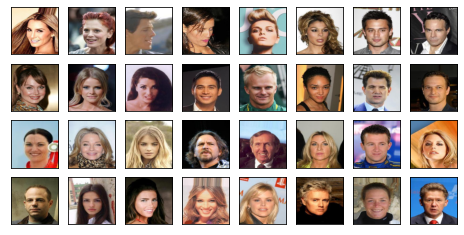

In [ ]:
def show(imgs):
  # your code goes here:
  fig = plt.figure(figsize=(8, 4))
  plot_size=32

  for idx in np.arange(plot_size):
    ax = fig.add_subplot(4, plot_size/4, idx+1, xticks=[], yticks=[])
    current = training_data[idx]

    for i in range(len(current)):
      image, label = current
      npimg = image.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
  return None

show(training_data)

### Part (c) -- 5%

Extrapolate in the image domain:

Here, randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

Explain the results, is extrapolation in the image domain reasonable?

Note: Recall that the images should be in the $[0,1]$ interval.

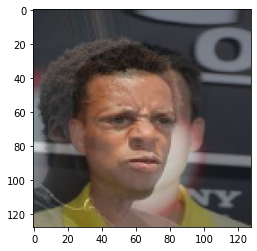

In [ ]:
# # Load the training dataset and select two random images

# X1, X2 = training_data[0][0], training_data[1][0] # CHANGE TO RANDOM

import random

# Select two random indices from the training dataset
indices = random.sample(range(len(training_data)), 2)

# Load the images at the selected indices
X1, X2 = training_data[indices[0]][0], training_data[indices[1]][0]

# Scale the images to the [0, 1] interval
X1 = (X1 - X1.min()) / (X1.max() - X1.min())
X2 = (X2 - X2.min()) / (X2.max() - X2.min())

X1 = X1.numpy()
X1 = np.transpose(X1, (1, 2, 0))

X2 = X2.numpy()
X2 = np.transpose(X2, (1, 2, 0))

# # Ensure that the tensors have the same shape by resizing one of the tensors
# if X1.shape != X2.shape:
#     # Get the output size for the spatial dimensions of X1
#     output_size = tuple(X1.shape[-2:])
#     # Resize X2 to have the same shape as X1
#     X2 = F.interpolate(X2, size=output_size)

# Extrapolate in the image domain by combining the two images with alpha = 0.5
alpha = 0.5
extrapolated_image = alpha * X1 + (1 - alpha) * X2

# Plot the extrapolated image
plt.imshow(extrapolated_image, cmap='gray')
plt.show()

### Your explanation goes here:

Extrapolation refers to estimating a value outside the range of known data. In the context of images, this could mean generating an image that is significantly different from any of the training images. While extrapolation can sometimes produce interesting results, it may also produce unrealistic or nonsensical images.

The reasonableness of an extrapolated image will depend on the specific task and the desired properties of the resulting images. For example, if the training dataset consists of images of animals, and you are trying to generate an image of a creature that has features from multiple animals, the resulting extrapolated image may not be reasonable. On the other hand, if the training dataset consists of images of abstract shapes, and you are trying to generate an image that combines features from multiple shapes, the resulting extrapolated image may be more reasonable.

In general, it is important to consider the context and the desired properties of the resulting images when deciding whether extrapolation is a reasonable approach.

## Question 3. VAE Foundations (15 %)


Let us start by recalling the analytical derivation of the VAE.


The simplest version of VAE is comprised of an encoder-decoder architecture.
The *encoder* is a neural network which its input is a datapoint $x$, its output is a hidden representation $z$, and it has weights and biases $\theta$. We denote the encoder's mapping by $P_{\theta}(z|x)$. The *decoder* is another neural network which its input is the data sample $z$, its output is the reconstructed input $x$, and its parameters $\phi$. Hence, we denote the decoder's mapping by $P_{\phi}(x|z)$.

The goal is to determine a posterior distribution $P_{\theta}(z|x)$ of a latent variable $z$ given some data evidence $x$. However, determining this posterior distribution is typically computationally intractable, because according to Bayes:

$(1)$ $P(z|x) = \frac{P(x|z)P(z)}{P(x)}$

The term $P(x)$ is called the evidence, and we can calculate it by marginalization on the latent variable:

$P(x) = \int_{z}P(x|z)P(z)dz$

Unfortunately, this term is intractable because it requires computation of the integral over the entire latent space $z$. To bypass this intractability problem we approximate the posterior distribution with some other distribution $q(z|x_i)$. This approximation is made by the KL-divergence:

$(2)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = \int_{z}q(z|x_i)\cdot\log\big(\frac{q(z|x_i)}{P(z|x_i)}\big)dz = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(z|x_i)}{q(z|x_i)}\big)dz \geq 0$

Applying Bayes’ theorem to the above equation yields,

$(3)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)P(x_i)}\big)dz \geq 0$

This can be broken down using laws of logarithms, yielding,

$(4)$ $-\int_{z}q(z|x_i)\cdot\big[\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)-\log(P(x_i))\big]dz \geq 0$

Distributing the integrand then yields,

$(5)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\int_{z}q(z|x_i)\log(P(x_i))dz \geq 0$

In the above, we note that $log(P(x))$ is a constant and can therefore be pulled out of the second integral above, yielding,

$(6)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i))\int_{z}q(z|x_i)dz \geq 0$

And since $q(z|x_i)$ is a probability distribution it integrates to 1 in the above equation, yielding,

$(7)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i)) \geq 0$

Then carrying the integral over to the other side of the inequality, we get,

$(8)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz$

<!-- Applying rules of logarithms, we get,

$(9)$ $\log(P(x)) \geq \int_{z}q(z|x)\cdot\big[\log\big(P(x|z)\big)+\log\big(P(z)\big)-\log\big(q(z|x)\big)\big]dz$

Recognizing the right hand side of the above inequality as Expectation, we write,

$(10)$ $\log(P(x)) \geq E_{~q(z|x)}\big[\log\big(P(x,z)\big)-\log\big(q(z|x)\big)\big]dz$ -->

From Equation $(8)$ it follows that:

$(9)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(z)}{q(z|x_i)}\big)dz + \int_{z}q(z|x_i)\cdot\log\big(P(x_i|z)\big)dz$

Which is equivalent to:

$(10)$ $\log(P(x_i)) \geq -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$



The right hand side of the above equation is the Evidence Lower BOund (ELBO). Its bounds $\log(P(x))$ which is the term we seek to maximize. Therefore, maximizing the ELBO maximizes the log probability of our data. 


### Part (a) -- 5%
 A we see above, the $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



## Write your explanation here

In a Variational Autoencoder (VAE), the Evidence Lower Bound (ELBO) is a measure of the fit of the model to the data. It is used as a loss function during training, with the goal of minimizing the ELBO. The ELBO is defined as:

$ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

The ELBO consists of two terms:

The first term is the Kullback-Leibler divergence (DKL) between the approximate posterior distribution $big(q(z|x_i)$ and the prior distribution P(z) . This term measures the difference between the two distributions and is used to encourage the approximate posterior to be similar to the prior.

The second term is the expected value of the log likelihood of the data under the approximate posterior, $E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$. This term measures how well the model is able to reconstruct the input data given the latent variables.

Together, these two terms form the ELBO, which is used as a loss function during training to optimize the VAE model. The goal is to minimize the ELBO, which will result in an approximate posterior that is similar to the prior and a model that is able to reconstruct the input data accurately.

### Part (b) -- 10%

 As we saw in class, in traditional variational autoencoder we assume:

$P(z)$ ~ $N(\mu_p,\sigma_{p}^2) = \frac{1}{\sqrt{2\pi\sigma_{p}^2}}\exp\big(-\frac{(x-\mu_p)^2}{2\sigma_{p}^2}\big)$

and

$q(z|x)$ ~ $N(\mu_q,\sigma_{q}^2) = \frac{1}{\sqrt{2\pi\sigma_{q}^2}}\exp\big(-\frac{(x-\mu_q)^2}{2\sigma_{q}^2}\big)$

Assume $\mu_p = 0$ and $\sigma_{p}^2 = 1$. Show that:

$ -D_{KL}\big(q(z|x_i)||P(z)\big) = \frac{1}{2}\big[1+\log(\sigma_{q}^2)-\sigma_{q}^2-\mu_q^2\big]$ 

 

**WRITE YOUR SOLUTIUON HERE**. (You can also upload your solution as an image.)


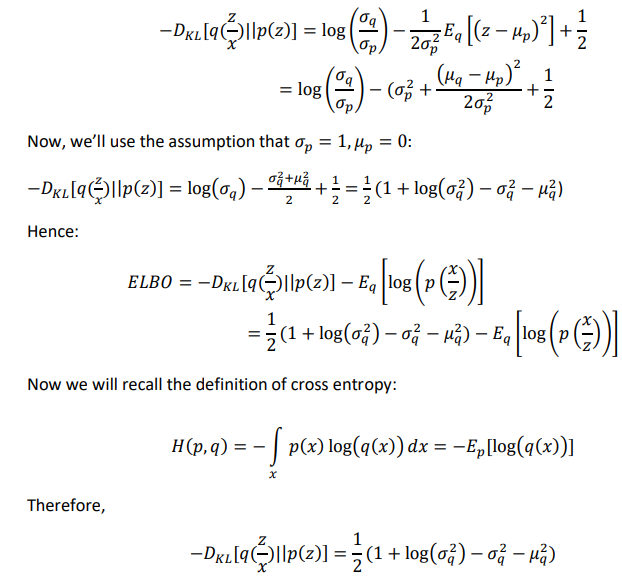




**Minimizing** the loss function, over a batch in the dataset now can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

## Question 4. VAE Implementation (25 %)

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** should reconstruct the images from the latent space. In order to enlarge dimensions of images, your network should be comprised of transposed convolutional layers (nn.ConvTranspose2d). See the following images of the operation of transpose convolution to better understand the way it works.




***Transposed Convolution with Stride = 1***

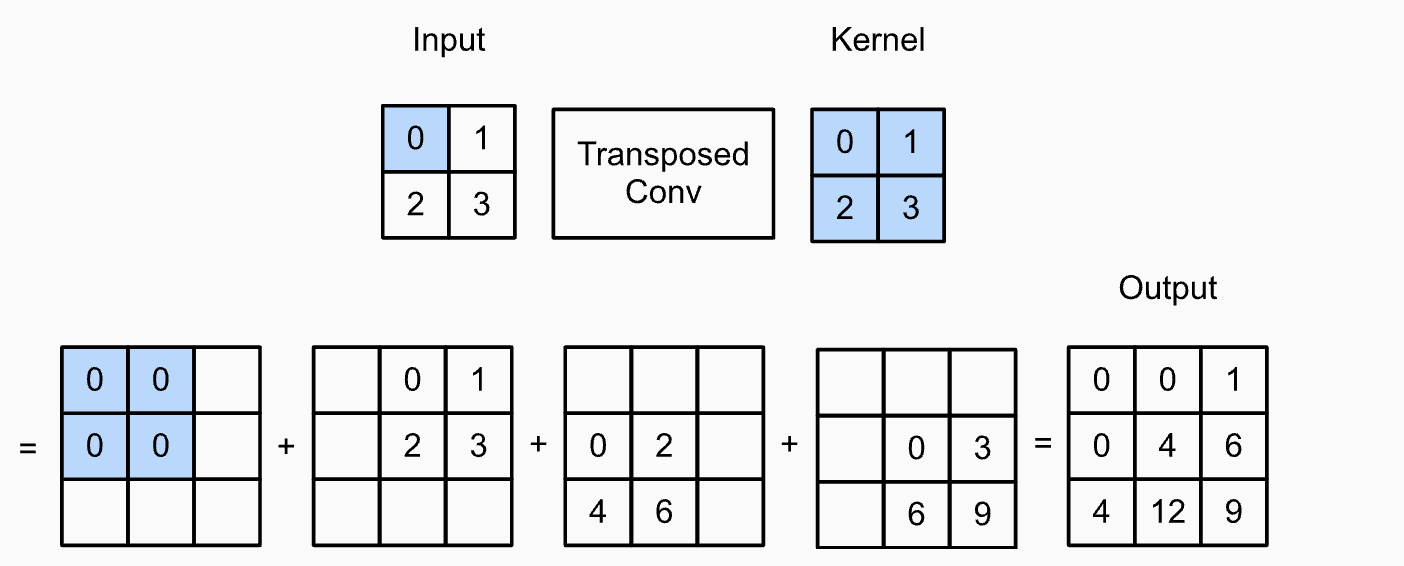

***Transposed Convolution with Stride = 2***
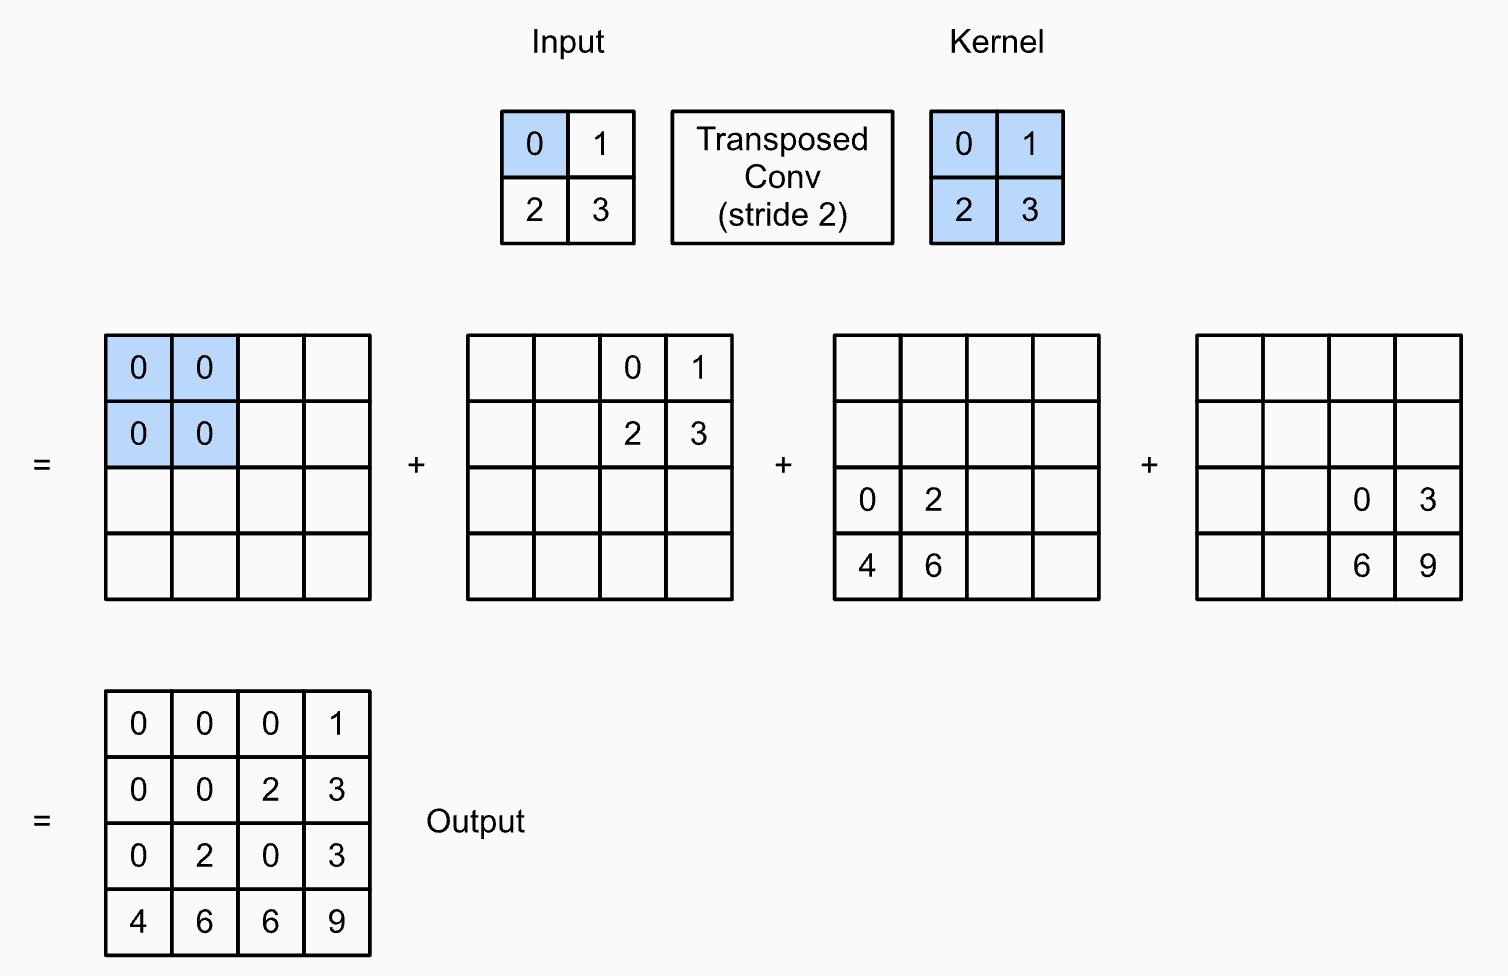

The architecture of your VAE network should be in the following form:


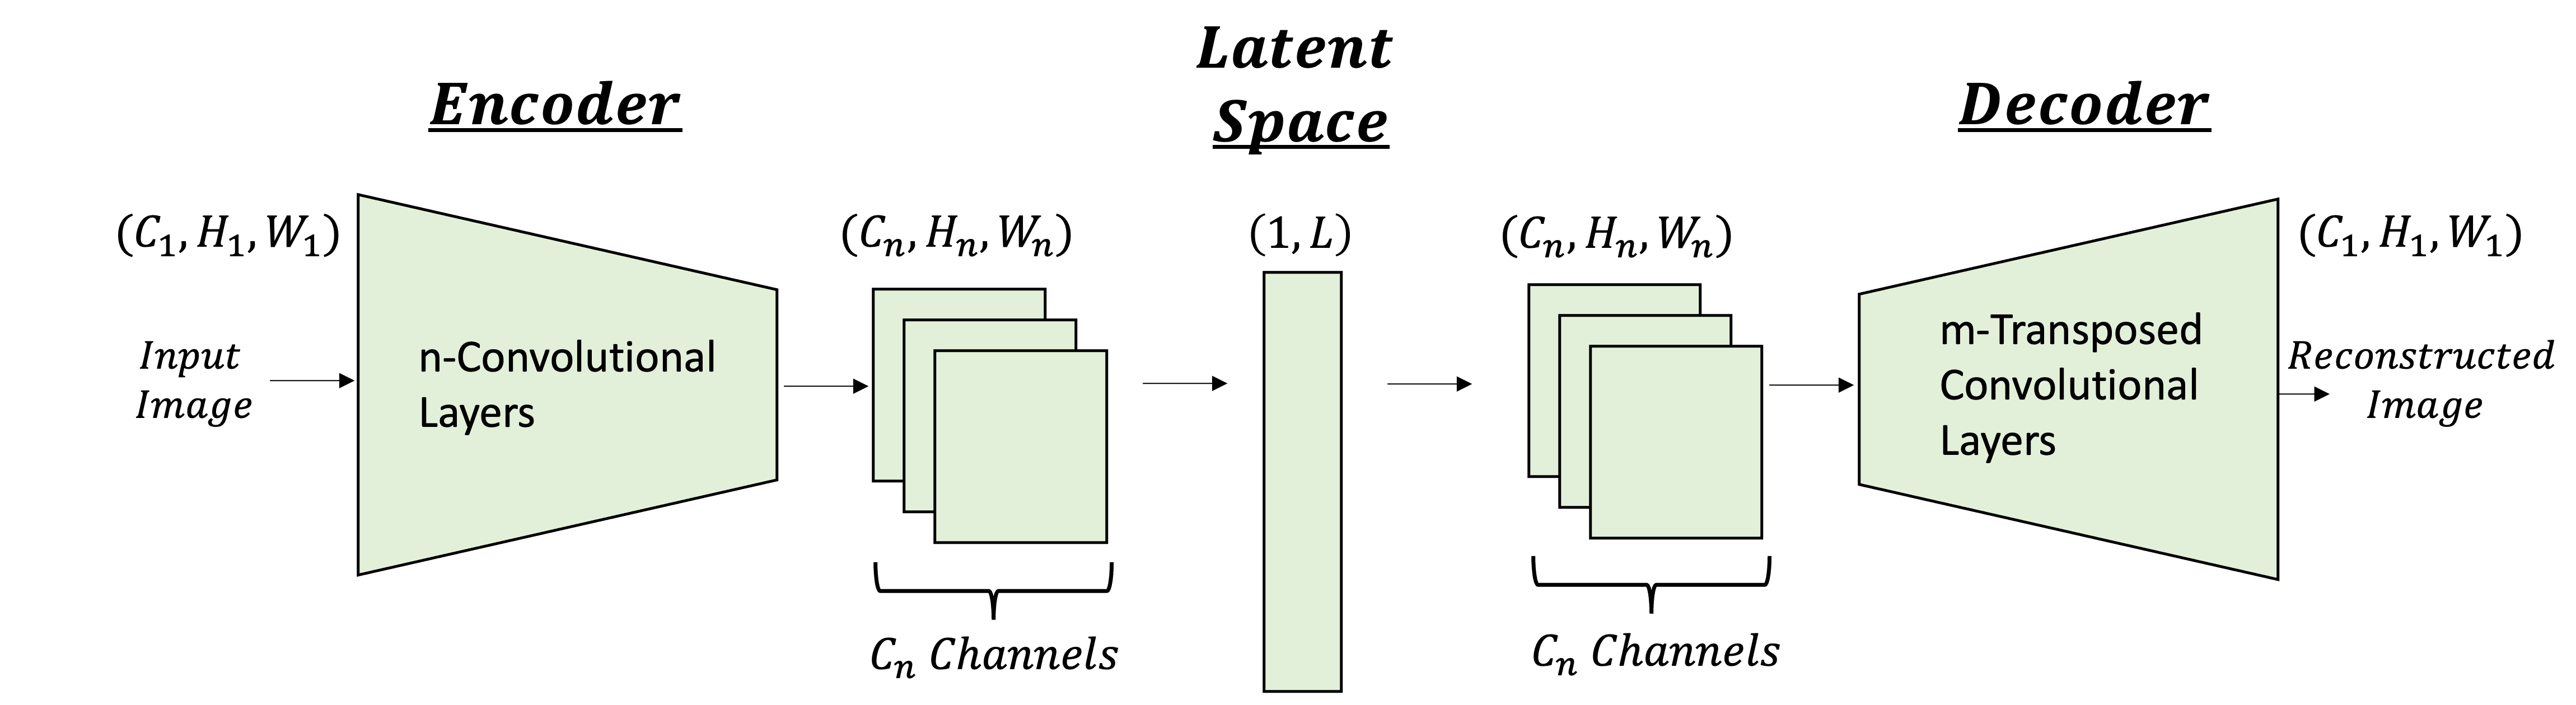

### Part (a) -- 7%

 **Encoder**

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(Batch\cdot H_4\cdot W_4\cdot C_4 , latent)$, where $(Batch$ is the batch size, $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).

**You can change any parameter of the network to suit your code - this is only a recommendation.**

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, in_channels, num_hiddens, latent):
#         super(Encoder, self).__init__()
#         # YOUR CODE GOES HERE:

#         self.num_hiddens = num_hiddens
#         self.latent = latent
#         self.block1 = nn.Sequential(...)
        
#         self.block2 = nn.Sequential(...)

#         self.block3 = nn.Sequential(...)
        
#         self.block4 = nn.Sequential(...)

#         self.fc_mu = (...,latent)     # Insert the input size
#         self.fc_logvar = (...,latent) # Insert the input size

#     def forward(self, inputs):
#         # YOUR CODE GOES HERE:


#         return mu, logvar

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent):
        super(Encoder, self).__init__()
        
        # Save the number of hidden units and latent size as instance variables
        self.num_hiddens = num_hiddens                          
        self.latent = latent

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2), padding=1), 
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
        )
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.BatchNorm2d(num_hiddens * 2),
            nn.ReLU()
        )
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(3,3), stride=(2,2),padding=1), 
            nn.BatchNorm2d(num_hiddens * 4),
            nn.ReLU()
        )
        # Block 4
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(3,3), stride=(2,2),padding=1), 
            nn.BatchNorm2d(num_hiddens * 8),
            nn.ReLU()
        )
        # Linear layers for mean and log variance
        self.fc_mu = nn.Linear(num_hiddens * 8 * 8 * 8, latent)
        self.fc_logvar = nn.Linear(num_hiddens * 8 * 8 * 8, latent)


    def forward(self, inputs):
        # Apply the blocks
        # print(inputs.shape)
        x = self.block1(inputs)
        # print(f'After block 1: {x.shape}')  # Print the shape of x after block 1
        x = self.block2(x)
        # print(f'After block 2: {x.shape}')  # Print the shape of x after block 2
        x = self.block3(x)
        # print(f'After block 3: {x.shape}')  # Print the shape of x after block 3
        x = self.block4(x)
        # print(f'After block 4: {x.shape}')  # Print the shape of x after block 4

        # Flatten the output
        x = x.view(x.size(0), -1)
        # print(f'After flattening: {x.shape}')  # Print the shape of

        # Compute the mean and log variance
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

In [ ]:
from torchsummary import summary

# Define the encoder model
encoder = Encoder(in_channels=3, num_hiddens=32, latent=3).to(torch.device('cuda:0'))

# Print the summary
summary(encoder, input_size=(3, 128, 128))#.to(torch.device('cuda:0'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Linear-13                    [-1, 3]          49,155
           Linear-14                   

**Notice: We output $\log\sigma$ and not $\sigma^2$, this is a convention when training VAEs but it is completely equivalent.**

### Part (b) -- 7%
 **Decoder**

Here, you will implement the architecture of the decoder. 

First, Apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer should match to $Batch\cdot H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we should generate an image in the same size as our input images. Thus add 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.

**NOTES:** 

- The output of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the  transposed convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output of the linear layer to ($Batch, H_4, W_4, C_4$)

- The output of the decoder should be of values in $[0,1]$.



**You can change any parameter of the network to suit your code, this is only a recommendation.**

In [ ]:
# class Decoder(nn.Module):
#     def __init__(self, in_channels, num_hiddens,latent):
#         super(Decoder, self).__init__()
#         # YOUR CODE GOES HERE:
#         self.num_hiddens = num_hiddens
#         self.fc_dec = nn.Linear(latent,...) # Insert the output size

#         self.block1 = nn.Sequential(...)
        
#         self.block2 = nn.Sequential(...)

#         self.block3 = nn.Sequential(...)
        
#         self.block4 = nn.Sequential(...)

#         self.block5 = nn.Sequential(...) # Add convolution layer and activation layer


#     def forward(self, inputs):
#         # YOUR CODE GOES HERE:
        
#         return x_rec

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent):
        super(Decoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.fc_dec = nn.Linear(latent, num_hiddens * 8 * 8)

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens, num_hiddens//2, kernel_size=(4,4), stride=(2,2), padding=1),
            nn.BatchNorm2d(num_hiddens//2),
            nn.LeakyReLU()
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens//2, num_hiddens//4, kernel_size=(4,4), stride=(2,2), padding=1),
            nn.BatchNorm2d(num_hiddens//4),
            nn.LeakyReLU()
        )
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens//4, num_hiddens//8, kernel_size=(4,4), stride=(2,2), padding=1),
            nn.BatchNorm2d(num_hiddens//8),
            nn.LeakyReLU()
        )
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens//8, num_hiddens//8, kernel_size=(4,4), stride=(2,2), padding=1),
            nn.BatchNorm2d(num_hiddens//8),
            nn.LeakyReLU()
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(num_hiddens//8, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs):
        # print(f'inputs: {inputs.shape}')
        x = self.fc_dec(inputs)
        # print(f'After fc_dec: {x.shape}')
        # x = x.view(-1, self.num_hiddens, 8, 8)
        x = x.view(x.size(0), self.num_hiddens,8,8)
        # print(f'After view: {x.shape}')
        x = self.block1(x)
        # print(f'After block 1: {x.shape}')
        x = self.block2(x)
        # print(f'After block 2: {x.shape}')
        x = self.block3(x)
        # print(f'After block 3: {x.shape}')
        x = self.block4(x)
        # print(f'After block 4: {x.shape}')
        x_rec = self.block5(x)
        # print(f'After block 5: {x_rec.shape}')
        return x_rec

In [ ]:
# # Import the torchsummary library
# from torchsummary import summary

# # Create an instance of the Decoder model
# decoder = Decoder(in_channels=256, num_hiddens=256, latent=3)

# # Print the summary
# summary(model=decoder, input_size=(2,4096), device='cpu')

### Part (c) -- 4% 
**VAE Model**

Once you have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

Remember that in VAEs, you need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.

Here, you should write the *forward()* function and to combine all the model's settings to a final network.

In [ ]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent):
        super(VAE, self).__init__()
        self.encode = Encoder(in_channels=enc_in_chnl, num_hiddens=enc_num_hidden,latent = latent)
        self.decode = Decoder(in_channels=dec_in_chnl, num_hiddens=dec_num_hidden,latent = latent)
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    # # Reparametrization Trick
    # def reparametrize(self, mu, logvar):
    #   std = torch.exp(0.5 * logvar)
    #   eps = torch.randn_like(std)     
    #   return eps.mul(std).add_(mu)

          # Reparametrization Trick
    def reparametrize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        # Encode the input image
        mu, logvar = self.encode(x)
        
        # Sample from the latent space using the reparametrization trick
        z = self.reparametrize(mu, logvar)
        
        # Decode the latent code to reconstruct the input image
        x_rec = self.decode(z)
        
        return x_rec , mu, logvar

### Part (d) -- 7% 

**Loss Function**

As we saw earlier, the loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

As seen in class, the fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

It is highly recommended to use the $\beta$-loss for increasing performance. 
 


Explain what could be the purpose of the hyperparameter $\beta$ in the loss function? If $\beta = 1$ is same as VAE, What is the effect of $\beta \neq 1$?

### Write your explanation here

The purpose of the hyperparameter beta (β) in the loss function of a β-VAE is to balance the two terms of the ELBO: the KL divergence term and the reconstruction term. By default, β is set to 1, which means that the loss function is equivalent to the ELBO of a traditional VAE.

However, when β is not equal to 1, it scales the KL divergence term by a factor of β. This allows the model to trade off between reconstruction accuracy and the KL divergence between the approximate posterior and the prior distribution.

If β is set to a value less than 1, it gives more weight to the reconstruction term and less weight to the KL divergence term. This can lead to better reconstruction accuracy at the cost of potentially having a less well-formed latent space. On the other hand, if β is set to a value greater than 1, it gives more weight to the KL divergence term and less weight to the reconstruction term. This can lead to a more well-formed latent space but potentially lower reconstruction accuracy.

In general, the value of β can be used to fine-tune the trade-off between reconstruction accuracy and the quality of the latent space in a β-VAE.

Here you should write specifically the code for the loss function.


In [ ]:
# beta = 0.1
# def vae_loss(x_recon, x, mu, logvar):
#     # YOUR CODE GOES HERE....
    
#     return BCE, KLD*beta
# beta = 0.1

# def vae_loss(x_recon, x, mu, logvar):
#     # Compute the reconstruction loss (negative log likelihood)
#     BCE = nnF.binary_cross_entropy(x_recon, x, reduction='sum')

#     # Compute the KL divergence term
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     # Compute the β-VAE loss
#     loss = (beta * KLD) - BCE
    
#     return BCE, KLD * beta

In [ ]:
beta = 0.1
def vae_loss(x_recon, x, mu, logvar):
    # Compute the reconstruction loss (mean squared error)
    BCE = nnF.mse_loss(x_recon, x, reduction='sum')
    # Compute the KL divergence term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Compute the β-VAE loss
    loss = (beta * KLD) - BCE

    return BCE, KLD * beta #BCE = MSE

In [ ]:
'''
The main difference is in the likelihood function of the data.
When assuming a Gaussian likelihood, we assume that the data is generated by a Gaussian distribution.
This allows us to model the reconstruction loss using mean squared error (MSE) between the original and reconstructed inputs,
as the MSE is the appropriate loss function for Gaussian data.
The KL divergence term is used to regularize the model by keeping the approximate posterior close to the prior.
This term is the same regardless of the assumption of the likelihood function as it depends on the nature of the VAE model, not the data.
***LINEAR LOSS AND NOT BETTER RESULTS***
'''

# beta = 0.1

# def gauss_likelihood(x_hat, logscale, x):
#     scale = torch.exp(logscale)
#     mean = x_hat
#     if x.shape != mean.shape:
#         diff = x.shape[0] - mean.shape[0]
#         x = x[diff:]
#     dist = torch.distributions.Normal(mean, scale)
#     log_pxz = dist.log_prob(x)
#     return log_pxz.sum(dim=(1, 2, 3))

# def vae_loss(x_recon, x, mu, logvar,log_scale):
#     recon_loss = gauss_likelihood(x_recon,log_scale,x)
#     # Compute the KL divergence term
#     KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=-1).mean(dim=0)

#     BCE = recon_loss.mean(dim=0)

#     return BCE, KLD*beta

'\nThe main difference is in the likelihood function of the data.\nWhen assuming a Gaussian likelihood, we assume that the data is generated by a Gaussian distribution.\nThis allows us to model the reconstruction loss using mean squared error (MSE) between the original and reconstructed inputs,\nas the MSE is the appropriate loss function for Gaussian data.\nThe KL divergence term is used to regularize the model by keeping the approximate posterior close to the prior.\nThis term is the same regardless of the assumption of the likelihood function as it depends on the nature of the VAE model, not the data.\n***LINEAR LOSS AND NOT BETTER RESULTS***\n'

In [ ]:
# beta = 0.1
# def vae_loss(x_recon, x, mu, logvar):
#     # Compute the reconstruction loss (mean absolute error)
#     BCE = nnF.l1_loss(x_recon, x, reduction='sum')
#     # Compute the KL divergence term
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     # Compute the β-VAE loss
#     loss = (beta * KLD) - BCE

#     return BCE, KLD * beta #BCE=MAE

 Here, define all the hyperparameters values for the training process. 

We gave you recommended values for the VAE model. You can modify and change it to suit your code better if needed.

In [ ]:
# learning_rate = ...
# batch_size = ...
# num_epochs = ...
# dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.

# #VAE Class inputs: 
# enc_in_chnl = 3
# enc_num_hidden = 32
# dec_in_chnl = 256
# dec_num_hidden = 256

learning_rate = 0.0005
batch_size = 64
num_epochs = 40 ###### We note that we can run for much more epochs and get better results.
dataset_size = 40000 # How many data samples to use for training, 30,000 should be enough.

# VAE class inputs:
enc_in_chnl = 3
enc_num_hidden = 32
dec_in_chnl = 256
dec_num_hidden = 256

In [ ]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

## Question 5. VAE Training (15 %)



### Part (a) -- 4% 
Complete the training function below

In [ ]:
def plot_loss_acc(num_epochs, train_loss, val_loss):
    # Plot the training and validation loss
    plt.plot(range(num_epochs), train_loss, label='Train Loss')
    plt.plot(range(num_epochs), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def train(num_epochs, batch_size, dataset_size, model):
    print("Start training")
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            imgs, _ = batch
            if torch.cuda.is_available():
                imgs = imgs.cuda()

            # Compute the VAE loss and update the model's parameters
            x_rec, mu, logvar = model(imgs)
            # print(f"x_rec {x_rec.shape}")
            # print(f"imgs {imgs.shape}")
            BCE, KLD = vae_loss(x_rec, imgs, mu, logvar)
            # BCE, KLD = vae_loss(x_rec, imgs, mu, logvar, model.log_scale)
            # print("After vae_loss")
            loss = BCE + KLD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate the lossover the epoch
            total_loss += loss.item()

            # Stop the training loop if we have reached the desired number of samples
            if dataset_size//batch_size == batch_idx: 
                break
        # Compute the average loss over the epoch
        avg_loss = total_loss / dataset_size
        train_losses.append(avg_loss)

        # Validation set
        with torch.no_grad():
            model.eval()
            total_loss = 0
            for batch_idx, batch in enumerate(test_loader):
                img, _ = batch
                if torch.cuda.is_available():
                    img = img.cuda()

                # Compute the VAE loss on the validation set
                x_rec, mu, logvar = model(img)
                BCE, KLD = vae_loss(x_rec, img, mu, logvar)
                # BCE, KLD = vae_loss(x_rec, imgs, mu, logvar, model.log_scale)
                loss = BCE + KLD
                total_loss += loss.item()

        # Compute the average loss on the validation set
        avg_loss_val = total_loss / len(test_loader.dataset)
        val_losses.append(avg_loss_val)

        # Print the epoch loss
        print(f'Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Loss: {avg_loss_val:.4f}')

    plot_loss_acc(num_epochs, train_losses, val_losses)

    return

### Part (b) -- 4%  

We first train with dimension of latent space $L=3$

We recommend to use *weight_init()* function, which helps stabilize the training process. 

In [ ]:
latent1 = 3

if torch.cuda.is_available():
    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1).cuda()
    model_1.weight_init(mean=0, std=0.02)
else:
    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1)
    model_1.weight_init(mean=0, std=0.02)

optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate,weight_decay=0)

Train your model, plot the train and the validation loss graphs. Explain what is seen.

Start training
Epoch 1 | Train Loss: 2125.5563 | Val Loss: 2035.7052
Epoch 2 | Train Loss: 2009.2712 | Val Loss: 1967.1430
Epoch 3 | Train Loss: 1974.2404 | Val Loss: 1955.8686
Epoch 4 | Train Loss: 1962.9537 | Val Loss: 1947.6962
Epoch 5 | Train Loss: 1953.8298 | Val Loss: 1942.0242
Epoch 6 | Train Loss: 1958.5160 | Val Loss: 1940.9708
Epoch 7 | Train Loss: 1942.0324 | Val Loss: 1941.1090
Epoch 8 | Train Loss: 1943.5684 | Val Loss: 1935.6949
Epoch 9 | Train Loss: 1941.1428 | Val Loss: 1934.7800
Epoch 10 | Train Loss: 1937.6334 | Val Loss: 1930.8999
Epoch 11 | Train Loss: 1940.0605 | Val Loss: 1929.2420
Epoch 12 | Train Loss: 1938.4638 | Val Loss: 1929.4440
Epoch 13 | Train Loss: 1946.7406 | Val Loss: 1925.7582
Epoch 14 | Train Loss: 1933.8309 | Val Loss: 1929.1684
Epoch 15 | Train Loss: 1926.5817 | Val Loss: 1925.3352
Epoch 16 | Train Loss: 1935.9398 | Val Loss: 1926.2511
Epoch 17 | Train Loss: 1939.4996 | Val Loss: 1923.3916
Epoch 18 | Train Loss: 1924.0201 | Val Loss: 1921.5888
Epoc

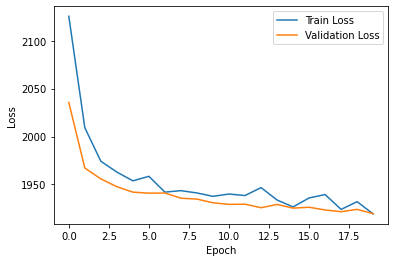

In [ ]:
train(20, batch_size, dataset_size, model_1)

### Explanation 

It looks like the training loss is decreasing and the validation loss is decreasing, but the training loss is higher than the validation loss at each epoch.

We can also conclude that the loss is very high, it can be from several reasons:
* The model might be under-capacity, meaning it doesn't have enough parameters to accurately model the data. This can happen if the latent space is too small, or if the model architecture is not powerful enough.
*The data might be particularly challenging to model. If the data is highly complex or highly varied, it might be difficult for the VAE to accurately reconstruct it, even with a larger latent space (We will check this in the next cells when we'll implement a larger latent size).

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Explain.

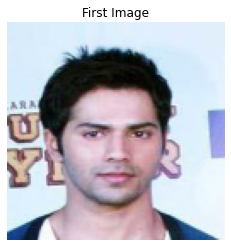

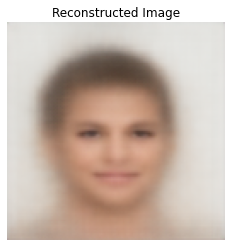

In [ ]:
# Your Code Goes Here

# Reshape the image data to [height, width, channels]
image = test_loader.dataset[5][0].permute(1, 2, 0)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('First Image')
plt.show()

# Add an extra dimension to the input tensor
input = test_loader.dataset[5][0].unsqueeze(0)

# Move the input tensor to the GPU
input = input.to('cuda')

# Use the VAE to reconstruct the first image
reconstructed_image, mu, logvar = model_1(input)

reconstructed_image = reconstructed_image.squeeze(0)

# Detach the reconstructed image from the computation graph
reconstructed_image = reconstructed_image.detach()

# Copy the reconstructed image to host memory
reconstructed_image = reconstructed_image.cpu()

# Plot the image
plt.imshow(reconstructed_image.permute(1, 2, 0))
plt.axis('off')
plt.title('Reconstructed Image')
plt.show()

### Explanation 

The model hasn't reconstructed the image successfully.

A small size of latent space in a Variational Autoencoder (VAE) means that there is less information available to reconstruct the original image, which can result in lower quality reconstructions. This is because the VAE has to compress the information from the input image into a lower-dimensional latent space, and then reconstruct the image from this compressed representation. If the latent space is too small, there may not be enough information available to accurately reconstruct the original image.

Additionally, if the VAE is not trained well, it may not have learned to effectively compress and reconstruct the input images, which can also lead to poor reconstructions. Finally, if the VAE architecture (e.g. number of layers, size of filters) is not well-suited for the task, it may also be difficult to get good reconstructions.

### Part (c) -- 7%  

Next, we train with larger $L > 3$

Based on the results for $L = 3$, choose a larger $L$ to improve your results.
Train new model with your choice for $L$.

In [ ]:
latent2 =  50 # TO DO: Choose latent space dimension.

if torch.cuda.is_available():
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2).cuda()
    model_2.weight_init(mean=0, std=0.02)
else:
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2)
    model_2.weight_init(mean=0, std=0.02)
    
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

Plot the train and the validation loss graphs. Explain what is seen.

Start training
Epoch 1 | Train Loss: 986.8263 | Val Loss: 683.6502
Epoch 2 | Train Loss: 661.9457 | Val Loss: 598.9303
Epoch 3 | Train Loss: 597.3112 | Val Loss: 582.8831
Epoch 4 | Train Loss: 583.0233 | Val Loss: 570.8023
Epoch 5 | Train Loss: 572.7469 | Val Loss: 567.1822
Epoch 6 | Train Loss: 565.4118 | Val Loss: 584.3107
Epoch 7 | Train Loss: 558.9490 | Val Loss: 554.0416
Epoch 8 | Train Loss: 555.6954 | Val Loss: 550.3572
Epoch 9 | Train Loss: 550.6536 | Val Loss: 545.6811
Epoch 10 | Train Loss: 546.7774 | Val Loss: 544.4775
Epoch 11 | Train Loss: 540.4301 | Val Loss: 540.3510
Epoch 12 | Train Loss: 539.3543 | Val Loss: 539.1446
Epoch 13 | Train Loss: 536.6877 | Val Loss: 540.6807
Epoch 14 | Train Loss: 532.4724 | Val Loss: 543.5162
Epoch 15 | Train Loss: 534.0883 | Val Loss: 535.4103
Epoch 16 | Train Loss: 529.5638 | Val Loss: 530.1084
Epoch 17 | Train Loss: 530.4376 | Val Loss: 531.1117
Epoch 18 | Train Loss: 526.8803 | Val Loss: 528.2014
Epoch 19 | Train Loss: 527.6135 | Val Lo

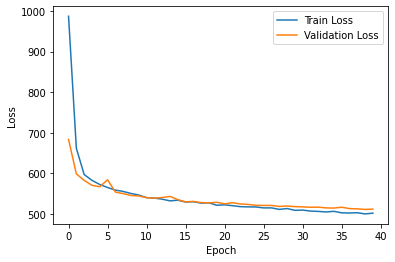

In [ ]:
# Your Code Goes Here
train(num_epochs, batch_size, dataset_size, model_2)

### Explanation

From the figure above, we can conclude that both train and validation are converging. We can also see that the loss is much less than before where the latent size was 3.

We can't conclude that this is the optimal model, however we can conclude (after hyper-parameters optimization) that this is the best model based on the model architecture provided above.

Based on the training and validation loss values provided, it looks like the VAE model is being trained on some sort of data, and the loss is being calculated at the end of each epoch. The loss values are decreasing over time, which is generally a good sign that the model is learning and improving. It is also worth noting that the training loss is consistently lower than the validation loss, which suggests that the model may be overfitting to the training data. This means that it is performing well on the training data, but may not generalize as well to new, unseen data. It is also possible that the model is reaching a point of diminishing returns, where the improvement in the loss becomes increasingly smaller with each epoch. Overall, it seems that the model is learning and improving, but it may be worth considering ways to reduce overfitting, such as using regularization techniques or decreasing the model's capacity.

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Are the images identical? Explain.

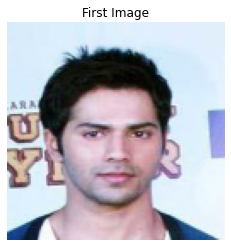

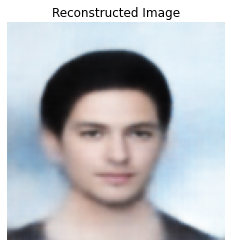

In [ ]:
# Your Code Goes Here

# Reshape the image data to [height, width, channels]
image = test_loader.dataset[5][0].permute(1, 2, 0)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('First Image')
plt.show()

# Add an extra dimension to the input tensor
input = test_loader.dataset[5][0].unsqueeze(0)

# Move the input tensor to the GPU
input = input.to('cuda')

# Use the VAE to reconstruct the first image
reconstructed_image, mu, logvar = model_2(input)

reconstructed_image = reconstructed_image.squeeze(0)

# Detach the reconstructed image from the computation graph
reconstructed_image = reconstructed_image.detach()

# Copy the reconstructed image to host memory
reconstructed_image = reconstructed_image.cpu()

# Plot the image
plt.imshow(reconstructed_image.permute(1, 2, 0))
plt.axis('off')
plt.title('Reconstructed Image')
plt.show()

### Explanation

From the figures above we can conclude that we can see the shape of the person very clearly.

This is because the VAE is able to effectively compress the information from the input image into the latent space, and then reconstruct the image from this compressed representation.

The optimal size of the latent space will depend on the complexity of the input images and the requirements of your specific application. In general, a larger latent space will be able to capture more information about the input images and should result in better reconstructions, but it will also be more computationally expensive. On the other hand, a smaller latent space will be less expensive to compute, but may not be able to capture as much information about the input images and may result in poorer reconstructions.

 What will happened if we choose extremely high dimension for the latent space?

In [ ]:
latent3 =  5000 # TO DO: Choose latent space dimension.

if torch.cuda.is_available():
    model_3 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent3).cuda()
    model_3.weight_init(mean=0, std=0.02)
else:
    model_3 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent3)
    model_3.weight_init(mean=0, std=0.02)
    
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

Start training
Epoch 1 | Train Loss: 1117.1421 | Val Loss: 615.0399
Epoch 2 | Train Loss: 445.0742 | Val Loss: 348.4881
Epoch 3 | Train Loss: 322.9935 | Val Loss: 295.5266
Epoch 4 | Train Loss: 280.5976 | Val Loss: 262.0655
Epoch 5 | Train Loss: 254.4949 | Val Loss: 241.0461
Epoch 6 | Train Loss: 228.7548 | Val Loss: 214.0993
Epoch 7 | Train Loss: 209.1882 | Val Loss: 199.8088
Epoch 8 | Train Loss: 194.6148 | Val Loss: 192.1553
Epoch 9 | Train Loss: 185.3410 | Val Loss: 181.0583
Epoch 10 | Train Loss: 174.2820 | Val Loss: 174.8383
Epoch 11 | Train Loss: 167.6668 | Val Loss: 169.6334
Epoch 12 | Train Loss: 160.2271 | Val Loss: 158.7668
Epoch 13 | Train Loss: 154.5493 | Val Loss: 151.9293
Epoch 14 | Train Loss: 148.8051 | Val Loss: 146.1302
Epoch 15 | Train Loss: 144.0512 | Val Loss: 141.3376
Epoch 16 | Train Loss: 139.2656 | Val Loss: 139.6301
Epoch 17 | Train Loss: 136.0187 | Val Loss: 134.2737
Epoch 18 | Train Loss: 131.0939 | Val Loss: 131.7029
Epoch 19 | Train Loss: 128.3074 | Val L

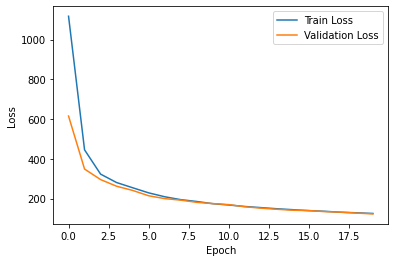

In [ ]:
# Your Code Goes Here
train(20, batch_size, dataset_size, model_3)

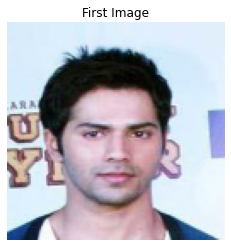

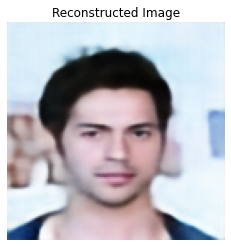

In [ ]:
# Your Code Goes Here

# Reshape the image data to [height, width, channels]
image = test_loader.dataset[5][0].permute(1, 2, 0)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title('First Image')
plt.show()

# Add an extra dimension to the input tensor
input = test_loader.dataset[5][0].unsqueeze(0)

# Move the input tensor to the GPU
input = input.to('cuda')

# Use the VAE to reconstruct the first image
reconstructed_image, mu, logvar = model_3(input)

reconstructed_image = reconstructed_image.squeeze(0)

# Detach the reconstructed image from the computation graph
reconstructed_image = reconstructed_image.detach()

# Copy the reconstructed image to host memory
reconstructed_image = reconstructed_image.cpu()

# Plot the image
plt.imshow(reconstructed_image.permute(1, 2, 0))
plt.axis('off')
plt.title('Reconstructed Image')
plt.show()

 
Did you output blurry reconstructed images? If the answer is yes, explain what could be the reason. If you got sharp edges and fine details, explain what you did in order to achieve that. 

Note: If you got blurry reconstructed images, just explain why. You dont need to change your code or retrain your model for better results (as long as your results can be interpreted as a human face).
 

### Explanation

When the dimension of the latent space in a VAE is increased, the model has more capacity to represent variations in the input data. This allows the VAE to generate more detailed and nuanced images, as it can encode more information about the original images in the latent space. However, it's worth noting that increasing the dimensionality of the latent space also increases the complexity of the model and the amount of data required to train it, which can lead to overfitting if not handled properly.

There are a few things we believe that can lead to achieve sharper edges and fine details in a VAE:

* Increase the dimensionality of the latent space: As I mentioned before, increasing the dimensionality of the latent space gives the model more capacity to represent variations in the input data, which can result in more detailed and nuanced images.

* Use a higher-resolution input: Training the VAE on higher resolution images can also result in sharper edges and fine details in the generated images, as there is more information for the model to work with.

* Use appropriate convolutional layers: Using convolutional layers with smaller kernels (e.g. 3x3) can help to capture fine details in the input images, while using larger kernels (e.g. 7x7) can help to capture larger structures.

* Use appropriate regularization: Regularization methods such as dropout and weight decay can help to prevent overfitting and therefore improve the generalization ability of the model, which will result in sharper edges and fine details in the generated images.

* Fine tuning the hyperparameters of the VAE such as the encoder and decoder architecture, learning rate, batch size, etc.

It's worth noting that finding the right balance between these different factors can be challenging and may require some experimentation to achieve the desired results.

## Question 6: Generate New Faces (10 %)

Now, for the fun part!

We are going to generate new celebrity faces with our VAE models. A function for new faces generation is given to you. Modify it (if needed) to fit your code. 



In [ ]:
def generate_faces(model, grid_size, latent):
    # Generate random noise
    dummy = torch.empty([batch_size,latent])
    z = torch.randn(batch_size,latent, device='cuda')*0.8 + 0
    # Pass the noise through the decoder
    generated_images = model.decode(z)

    # Detach the generated images from the computation graph
    generated_images = generated_images.detach()

    # Copy the generated images to host memory
    generated_images = generated_images.cpu()

    fig, axs = plt.subplots(4, 8, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    axs = axs.ravel()
    for i, image in enumerate(generated_images):
        if i >= len(axs):
            break
        # Convert the image data to an RGB format
        image = image.permute(1, 2, 0)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

**Model 1 ($L = 3$) results:**

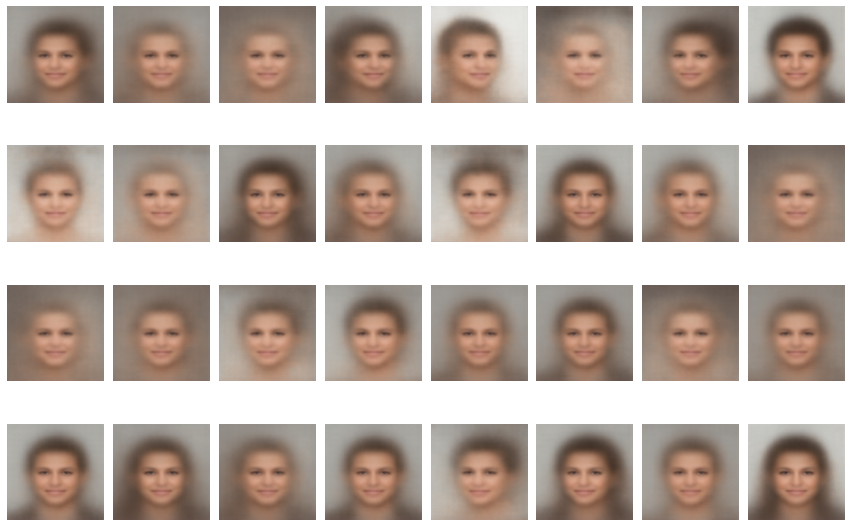

In [ ]:
generate_faces(model_1,grid_size=32,latent=latent1)

**Model 2 results:**

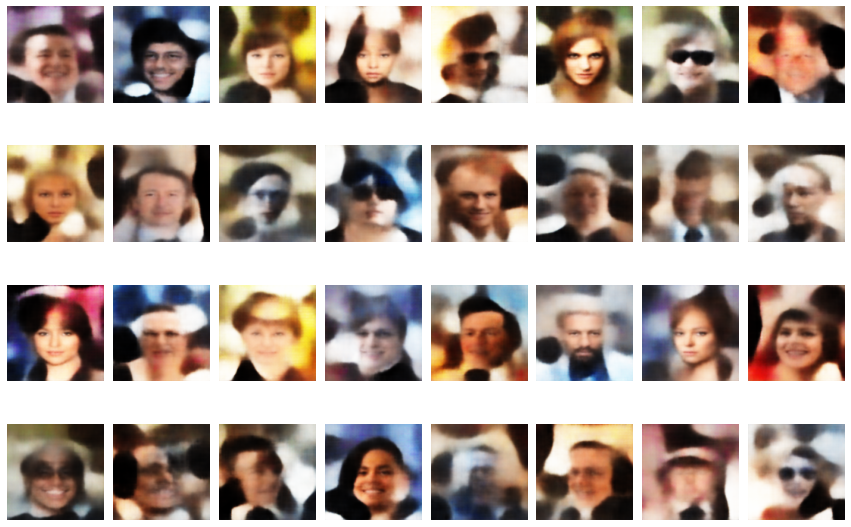

In [ ]:
generate_faces(model_2,grid_size=32,latent=latent2)

*Q1:* Generate new faces with VAE model with latent space dimension = 3. Did you get diverse results? What are the most prominent features that the latent space capture? 

*Q2:* Generate new faces with VAE model with your decision for latent space dimension. What are the most prominent features that the latent space capture? 

*Q3:* What are the differences? Your results are similar to the dataset images? Do you get realistic images for your chosen latent space dimension? If not, change your decision or your network to acheive more realistic results.

### YOUR ANSWERS GOES HERE

* Q1 Answer: In general, VAEs are designed to capture the most prominent features of the input data in the latent space, such as variations in shape, texture, or color. However, with a lower dimensionality, it could be more prone to oversimplifying the information, therefore leading to less diverse outputs. From a quick view on the pictures we can see that their shade, faces and hair are a bit not diverse.

* Q2 Answer: The model is likely capturing a wider range of features in the input images, including the positioning of the face, hair style, background color, beard style, mouth style, and clothes.
A latent space with a good dimension, it should allow the VAE to encode and decode the most important information in the images, allowing the model to generate outputs that are more similar to the input images, while maintaining a high degree of diversity. Additionally, high dimensional space can also allows for more nuanced variations on the features within the encoded data, leading to more diverse outputs. We know that we could have run for much more epochs and we will get better results with much less black and not so realistic pixels.

* Q3 Answer: As shown above there is a significant improvement between the reconstruction of the images when the latent value is initialize as 3 and 50. Although there is room for improvement, the result for latent 50 are more realistic than the unnuanced reconstruction with latent=3. comparision with the given dataset will clarify the improvement by latent 50 and are much closer to a quality and realistic reconstruction. A low-dimensional latent space in a variational autoencoder (VAE) means that the encoded representation of the input data has fewer dimensions compared to the original data, while a high-dimensional latent space has more dimensions. If the latent space is low-dimensional, the VAE will learn a compact representation of the input data, which may lead to loss of information and less realistic generated images. However, a high-dimensional latent space can capture more information from the input data, and thus can lead to more realistic generated images. The results may be similar to the dataset images if the VAE is well-trained, and the dimensions of the latent space are chosen appropriately for the specific task and dataset. Higher latent space dimensions can lead to more realistic images because it can capture more information about the input data distribution, and the decoder network can use this information to generate more detailed and diverse images. Additionally, a high-dimensional latent space can also encourage the VAE to learn a more expressive and flexible probabilistic model of the input data, which can also lead to more realistic images.

## Question 7: Extrapolation (10 %)

Recall that we extrapolate in the images domain in Question 2, part (c).
Here, extrapolate in the latent space domain to generate new images.

Define $\beta = [0, 0.1, 0.2, ... , 0.9, 1]$ and randomly sample from $Z \sim \mathcal{N(0,1)}$ 2 different samples and generate 2 new face images: $X_1, X_2$.

Extrapolate in the latent domain as follows: $\beta_i\cdot Z_1 + (1-\beta_i)\cdot Z_2$ for each $\beta_i \in \beta$.

Plot the extrapolation of the images for each $\beta$ and discuss your results. 
Repeat the process for 3 different samples.



In [ ]:
# YOUR CODE GOES HERE
def extrapolation(model, latent):
  # Define the beta values
  beta = torch.linspace(0, 1, 11)

  # Generate random noise
  dummy = torch.empty([1,latent])

  random1 = random.randint(1,10)
  random2 = random.randint(1,10)

  z1 = random1*torch.randn_like(dummy).to(device)
  z2 = random2*torch.randn_like(dummy).to(device)

  X1 = model.decode(z1)
  X2 = model.decode(z2)

  fig, axes =plt.subplots(1,2)
  axes[0].imshow(X1.cpu().detach().numpy()[0].transpose(1,2,0))
  axes[0].set_title("Original 1")
  axes[0].axis("off")
  axes[1].imshow(X2.cpu().detach().numpy()[0].transpose(1,2,0))
  axes[1].set_title("Original 2")
  axes[1].axis("off")
  plt.tight_layout()
  plt.show()
  plt.figure(figsize=(10, 4)) 

  #for each beta, calculate b*z1+(1-b)*z2 and decode to get new image
  for a in range(10):
    plt.subplot(2, 5, a+1)
    sample=model.decode(beta[a]*z1+(1-beta[a])*z2)
    plt.imshow(sample[0].cpu().permute(1,2,0).detach().numpy())
    plt.axis('off')

  plt.show()

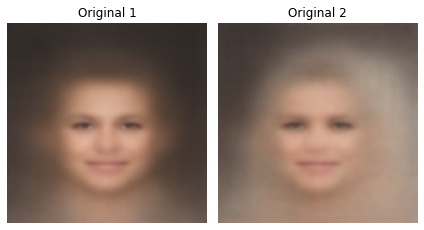

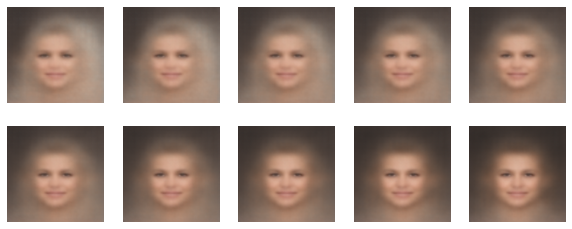

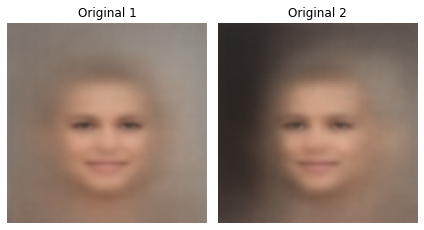

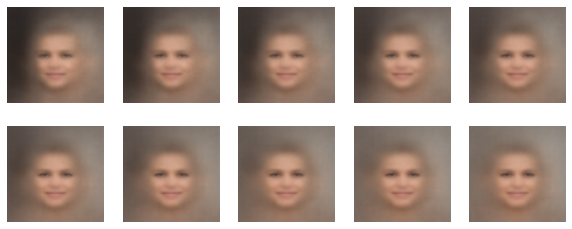

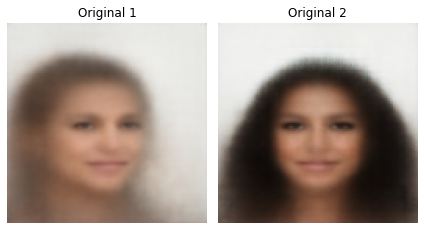

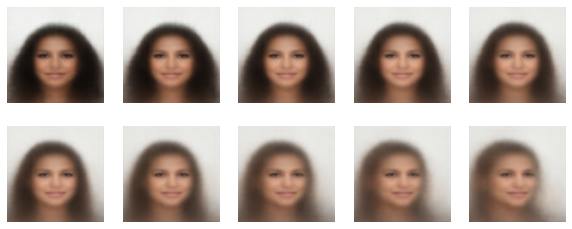

In [ ]:
extrapolation(model_1, latent1)
extrapolation(model_1, latent1)
extrapolation(model_1, latent1)

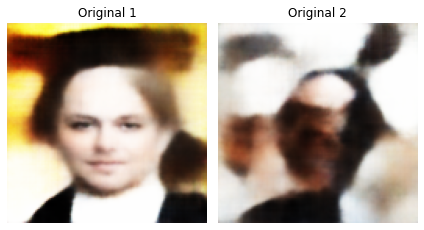

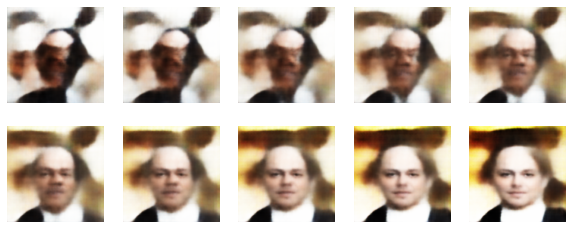

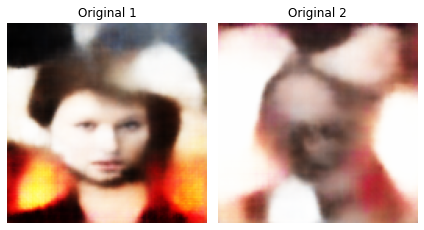

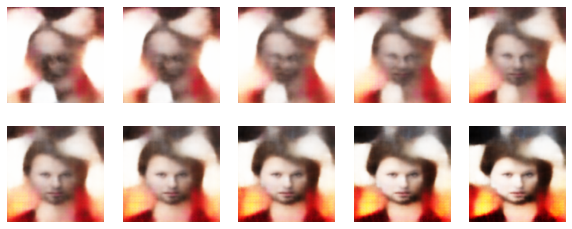

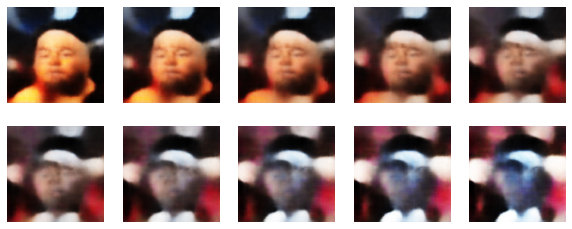

In [ ]:
extrapolation(model_2, latent2)
extrapolation(model_2, latent2)
extrapolation(model_2, latent2)

### Summary & Discussion

The extrapolation in the latent space domain is a process of generating new images by interpolating between two existing images, X1 and X2, in the latent space. This is done by defining a set of values, β, that range from 0 to 1, and for each value of β, calculating a new point in the latent space as βi*Z1 + (1-βi)*Z2. Then, passing this new point through the decoder of the model will generate a new image in the image space.

When we perform this extrapolation, we can observe that as the value of β increases, the generated image moves closer to X1, and as the value of β decreases, the generated image moves closer to X2. This means that as β approaches 0, the generated image becomes more similar to X2 and as β approaches 1, the generated image becomes more similar to X1.

Additionally, we can also notice that the transition between the two images is smooth as we change the value of β, indicating that the interpolation between the two images in the latent space is a continuous process.

In summary, extrapolating in the latent space allows us to generate new images by interpolating between two existing images in a smooth and continuous manner. This can be useful for tasks such as data augmentation, style transfer, and image editing.